In [1]:
# TODO
# curve visualisation with interpolation of tracks/find alternative data

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import gtc_functions
# having issues with circular dependencies here

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
from geopy.distance import geodesic


# remove these once scripts have been transferred
from tqdm import tqdm
from typing import Tuple,List,Union
import os
import numpy as np
import urllib
import requests

## Loading in weather station data

Load in list of weather stations. This file can be found at the bottom of this [webpage](https://www.ncei.noaa.gov/pub/data/noaa/).

*TODO*: get this on the drive and interact with it remotely. 


In [5]:
# date formats are specified
df_stations_all = pd.read_csv('isd-history.csv',parse_dates=['BEGIN','END'])
df_stations_all = gtc_functions.standardiseDfs(df_stations_all)
df_stations_all.head(10)

,usaf,wban,station_name,ctry,state,icao,lat,lon,elev(m),begin,end,geometry
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,2011-03-09,2013-07-30,POINT (0 0)
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,2012-07-13,2017-08-22,POINT (0 0)
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,2014-09-23,2015-09-26,POINT (0 0)
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,2005-01-01,2012-07-31,POINT (0 0)
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,2010-05-19,2012-03-23,POINT (65.567 32.95)
5,008307,99999,WXPOD 8318,AF,NaN,NaN,0.00,0.000,8318.0,2010-04-21,2010-04-21,POINT (0 0)
6,008411,99999,XM20,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-17,2016-02-17,POINT EMPTY
7,008414,99999,XM18,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-16,2016-02-17,POINT EMPTY
8,008415,99999,XM21,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-17,2020-03-14,POINT EMPTY
9,008418,99999,XM24,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-17,2016-02-17,POINT EMPTY


In [6]:
print(f'There are {len(df_stations_all)} weather stations available.')

There are 29630 weather stations available.


## Visualise time ranges of various weather stations

In [7]:
# approximate lat/lon ranges of interest
lat_range = [10,40]
lon_range = [-90,-60]

# stations dataframe limited to region of interest 
df_limited_stations = gtc_functions.rangeExclude(df_stations_all,['lat','lon'],[lat_range,lon_range])
print('number of stations within lat-lon range: ',len(df_limited_stations))

number of stations within lat-lon range:  2068


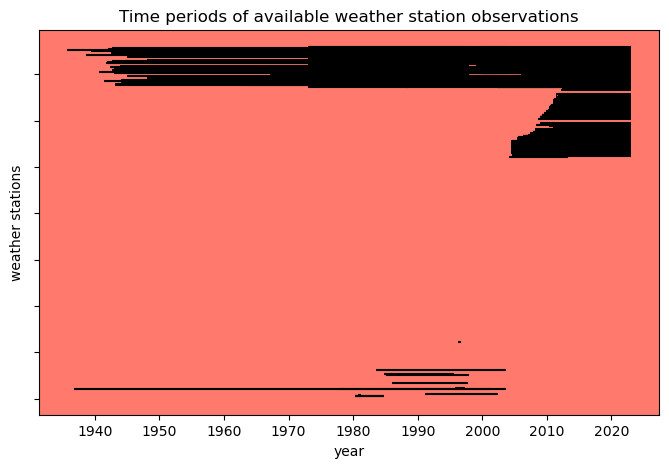

In [8]:
# set number of stations to include (helps visualise data availability): -1 = all
num_stations = 500

# Plot graph of observation time periods
fig, ax = plt.subplots(figsize=(8, 5))
plt.hlines(df_limited_stations.index[:num_stations], 
    df_limited_stations.begin[:num_stations], df_limited_stations.end[:num_stations],
    color='k')

# formatting
ax.set_facecolor('xkcd:salmon')
ax.set_xlabel('year');
ax.set_ylabel('weather stations');
ax.set_yticklabels([])
ax.set_title('Time periods of available weather station observations');

It's clear that many stations do not have records over the time of interest: these will have to be filtered out.

## Weather data format

Weather station records are stored in the following format, with https://www.ncei.noaa.gov/data/global-hourly/access/ as the parent url:
```
- year 1 (1901)
- year 2 (1902)
    - station_id 1 (e.g. 01001099999.csv)
    - station_id 2
    - ...
    - station_id N
- year 3 (1903)
- ...
- year 122 (2023)
```

Will need to figure out a way to fetch the right date ranges for the necessary weather stations and upload the data to the shared Google. Suggest using [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and/or [httplib2](https://pypi.org/project/httplib2/), potentially with a plugin allowing download direct to Drive (bypassing local download) such as [Save to Google Drive extension](https://chrome.google.com/webstore/detail/save-to-google-drive/gmbmikajjgmnabiglmofipeabaddhgne).

The station_ids are generated by combining the USAF(US Air Force) and WBAN (a five-digit station identifier used at NCEI for digital data storage and general station identification purposes) of each station. This is generated below:

In [9]:
# remove rows with any key data missing
df_stations = df_stations_all.dropna(subset=['lat','lon','usaf','wban'])
print(f'{len(df_stations_all)-len(df_stations)} weather stations had key information missing so were removed')

# TODO: may be useful to visualise the prevelance of missing data

1187 weather stations had key information missing so were removed


In [10]:
df_stations

,usaf,wban,station_name,ctry,state,icao,lat,lon,elev(m),begin,end,geometry
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.000,0.000,7018.0,2011-03-09,2013-07-30,POINT (0 0)
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.000,0.000,7026.0,2012-07-13,2017-08-22,POINT (0 0)
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.000,0.000,7070.0,2014-09-23,2015-09-26,POINT (0 0)
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.000,0.000,0.0,2005-01-01,2012-07-31,POINT (0 0)
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.950,65.567,1156.7,2010-05-19,2012-03-23,POINT (65.567 32.95)
...,...,...,...,...,...,...,...,...,...,...,...,...
29625,A07355,241,VIROQUA MUNICIPAL AIRPORT,US,WI,KY51,43.579,-90.913,394.1,2014-07-31,2023-01-20,POINT (-90.913 43.579)
29626,A07357,182,ELBOW LAKE MUNICIPAL PRIDE OF THE PRAIRIE AIRPORT,US,MN,KY63,45.986,-95.992,367.3,2014-07-31,2023-01-21,POINT (-95.992 45.986)
29627,A07359,240,IONIA COUNTY AIRPORT,US,MI,KY70,42.938,-85.061,249.0,2014-07-31,2023-01-21,POINT (-85.061 42.938)
29628,A51255,445,DEMOPOLIS MUNICIPAL AIRPORT,US,AL,KDYA,32.464,-87.954,34.1,2014-07-31,2023-01-07,POINT (-87.954 32.464)


In [11]:
# generating filename of hourly weather data 
df_stations = gtc_functions.concatDfsCols(df_stations,'csv_filenames',['usaf','wban'])

/Users/orlandotimmerman/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/mres/gtc/datasets/gtc_functions.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[concatted_col_name] = df[cols_to_concat].astype(str).apply(


In [12]:
df_stations

,usaf,wban,station_name,ctry,state,icao,lat,lon,elev(m),begin,end,geometry,csv_filenames
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.000,0.000,7018.0,2011-03-09,2013-07-30,POINT (0 0),00701899999
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.000,0.000,7026.0,2012-07-13,2017-08-22,POINT (0 0),00702699999
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.000,0.000,7070.0,2014-09-23,2015-09-26,POINT (0 0),00707099999
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.000,0.000,0.0,2005-01-01,2012-07-31,POINT (0 0),00826099999
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.950,65.567,1156.7,2010-05-19,2012-03-23,POINT (65.567 32.95),00826899999
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29625,A07355,241,VIROQUA MUNICIPAL AIRPORT,US,WI,KY51,43.579,-90.913,394.1,2014-07-31,2023-01-20,POINT (-90.913 43.579),A07355241
29626,A07357,182,ELBOW LAKE MUNICIPAL PRIDE OF THE PRAIRIE AIRPORT,US,MN,KY63,45.986,-95.992,367.3,2014-07-31,2023-01-21,POINT (-95.992 45.986),A07357182
29627,A07359,240,IONIA COUNTY AIRPORT,US,MI,KY70,42.938,-85.061,249.0,2014-07-31,2023-01-21,POINT (-85.061 42.938),A07359240
29628,A51255,445,DEMOPOLIS MUNICIPAL AIRPORT,US,AL,KDYA,32.464,-87.954,34.1,2014-07-31,2023-01-07,POINT (-87.954 32.464),A51255445


## Visualising weather station distribution

In [13]:
#TODO: expand search

# generate geopandas dataframe for visualising weather station distribution against a world map
stations_gdf = gpd.GeoDataFrame(df_stations,geometry=gpd.points_from_xy(df_stations.lon,df_stations.lat))
gdf_stations_limited = gpd.GeoDataFrame(df_limited_stations,geometry=gpd.points_from_xy(df_limited_stations.lon,df_limited_stations.lat)) 

In [14]:
# fetch worldmap and format plot size
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
plt.rcParams['figure.figsize'] = [13, 7]

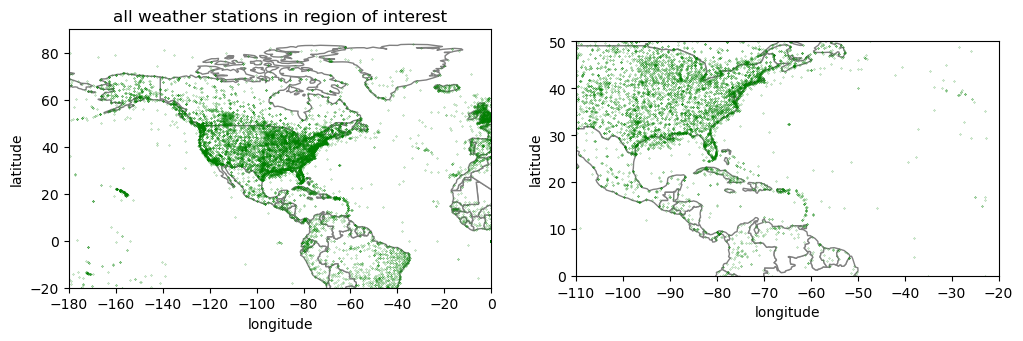

In [15]:
fig, ax = plt.subplots(1,2,figsize=[12,5]);

for i in range(len(fig.axes)):
    ax[i].set_xlabel('longitude'), ax[i].set_ylabel('latitude')
    world.plot(ax=ax[i],color='white',edgecolor='grey')
    stations_gdf.plot(ax=ax[i],color='green',markersize=0.05,alpha=0.8);

ax[0].set_xlim([-180,0]);
ax[0].set_ylim([-20,90]);
ax[0].set_title('all weather stations in NA');

ax[1].set_xlim([-110,-20]);
ax[1].set_ylim([0,50]);
ax[0].set_title('all weather stations in region of interest');

## Load in NOAA 6-hourly weather dataset

In [16]:
weather_data_dir_path =  '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/'

# noaa 6-hourly
df_noaa_pkl_name = 'noaa_hurricanes.pkl'
df_noaa_hurricanes = pd.read_pickle(weather_data_dir_path+df_noaa_pkl_name)

# noaa 6-hourly xbd
df_noaa_xbd_pkl_name = 'noaa_xbd_hurricanes.pkl'
df_noaa_xbd_hurricanes = pd.read_pickle(weather_data_dir_path+df_noaa_xbd_pkl_name)

In [17]:
# convert to pd.DataFrame to gpd.GeoDataFrame, specifying latitude and longitude columns
gdf_noaa_hurricanes = gpd.GeoDataFrame(df_noaa_hurricanes,geometry=gpd.points_from_xy(df_noaa_hurricanes.lon,df_noaa_hurricanes.lat))
gdf_noaa_xbd_hurricanes = gpd.GeoDataFrame(df_noaa_xbd_hurricanes,geometry=gpd.points_from_xy(df_noaa_xbd_hurricanes.lon,df_noaa_xbd_hurricanes.lat))

In [18]:
# restrict hurricanes df to those for which any kind of satellite data will exist
# (approximately the 70s)
df_satellite = df_noaa_hurricanes[df_noaa_hurricanes['date'] >= pd.Timestamp('1970-01-01')]

# restrict hurricanes df to those of cat-3 and above
df_satellite_strong = df_satellite[df_satellite['strength'] >= 3]

# restrict hurricanes df to xbd events
xbd_hurricane_names = ['MICHAEL','MATTHEW','FLORENCE','HARVEY']
df_xbd_hurricanes = gtc_functions.mostRecentEventsByName(df_noaa_hurricanes,xbd_hurricane_names)

In [19]:
# number of 6-hour intervals spanning xbd hurricanes in the Atlantic
num_6s = len(df_xbd_hurricanes)
print('number of 6-hour intervals spanning xbd hurricanes in the Atlantic: ', num_6s)
# number of 1-hour intervals spanning hurricanes in the Atlantic
# approximate since coarse (may have a couple of hours of weather caused the same
# storm on either end)
num_hourly = num_6s * 6
print('approximate number of 1-hour intervals spanning xbd hurricanes in the Atlantic: ', num_hourly)

number of 6-hour intervals spanning xbd hurricanes in the Atlantic:  241
approximate number of 1-hour intervals spanning xbd hurricanes in the Atlantic:  1446


### Load xBD Data 

In [20]:
# pkl path (TODO: point to correct drive dir – will do via Owen's directory.py code)
# it should also check that this is a valid path
pkl_path = gtc_functions.pathExists('/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/xBD_data/df_points_posthurr.pkl')
# load in pkl file to dataframe
df_points_xbd = pd.read_pickle(pkl_path)
df_points_xbd
# loads with 'geometry' column of points being strings

,geometry,damage_class,disaster_name,capture_date
0,POINT (-77.9244320492178 34.78850199541164),2,hurricane-florence,2018-09-20T16:04:41.000Z
1,POINT (-77.92458589472702 34.78817409635829),1,hurricane-florence,2018-09-20T16:04:41.000Z
2,POINT (-85.61007417082075 30.200042174373575),0,hurricane-michael,2018-10-13T16:48:15.000Z
3,POINT (-85.61056875858309 30.20001239764311),0,hurricane-michael,2018-10-13T16:48:15.000Z
4,POINT (-85.6105468715275 30.20060087544323),1,hurricane-michael,2018-10-13T16:48:15.000Z
...,...,...,...,...
23049,POINT (-77.91796670865669 34.64623298093464),0,hurricane-florence,2018-09-20T16:04:41.000Z
23050,POINT (-77.91772594373008 34.64627829178596),0,hurricane-florence,2018-09-20T16:04:41.000Z
23051,POINT (-77.9176517767119 34.646497499155615),0,hurricane-florence,2018-09-20T16:04:41.000Z
23052,POINT (-77.91835147876859 34.64612284454794),0,hurricane-florence,2018-09-20T16:04:41.000Z


In [21]:
gtc_functions.standardiseDfs(df_points_xbd,date_cols=['capture_date'])


# # convert POINT strings to POINT object
# df_points_xbd['geometry'] = df_points_xbd['geometry'].apply(lambda x: gtc_functions.pointStrToPoint(x))
# # convert date strings to pd.Timestamp objects
# df_points_xbd['capture_date'] = pd.to_datetime(df_points_xbd['capture_date'])
# remove 'hurricane' section of name N.B. won't be necessary for hourly: this
# will just use the date and closest location(s)
df_points_xbd['disaster_name'] = df_points_xbd['disaster_name'].apply(lambda x: x.split('-')[-1]).str.upper()

df_points_xbd

# TODO: would be good to visualise the length of time between the disaster and 
# the satellite observation

,geometry,damage_class,disaster_name,capture_date,lon,lat
0,POINT (-77.92443 34.78850),2,FLORENCE,2018-09-20 16:04:41+00:00,-77.924432,34.788502
1,POINT (-77.92459 34.78817),1,FLORENCE,2018-09-20 16:04:41+00:00,-77.924586,34.788174
2,POINT (-85.61007 30.20004),0,MICHAEL,2018-10-13 16:48:15+00:00,-85.610074,30.200042
3,POINT (-85.61057 30.20001),0,MICHAEL,2018-10-13 16:48:15+00:00,-85.610569,30.200012
4,POINT (-85.61055 30.20060),1,MICHAEL,2018-10-13 16:48:15+00:00,-85.610547,30.200601
...,...,...,...,...,...,...
23049,POINT (-77.91797 34.64623),0,FLORENCE,2018-09-20 16:04:41+00:00,-77.917967,34.646233
23050,POINT (-77.91773 34.64628),0,FLORENCE,2018-09-20 16:04:41+00:00,-77.917726,34.646278
23051,POINT (-77.91765 34.64650),0,FLORENCE,2018-09-20 16:04:41+00:00,-77.917652,34.646497
23052,POINT (-77.91835 34.64612),0,FLORENCE,2018-09-20 16:04:41+00:00,-77.918351,34.646123


In [22]:
# def closestStation(df_weather: pd.DataFrame,
#                 df_stations: pd.DataFrame,
#                 distance_buffer: float,
#                 df_xbd_obs: pd.DataFrame,
#                 time_buffer: Tuple[float,str]
#     ) -> pd.DataFrame:
#     """TODO: docstring, separate out, and generalise"""

#     # find date column
#     date_col = df_weather.columns[df_weather.dtypes == 'datetime64[ns]'].tolist()[0]

#     # pre-assign column of values
#     df_xbd_obs['index_closest'] = np.nan
#     df_xbd_obs['event_start'] = np.nan
#     df_xbd_obs['event_end'] = np.nan
#     # generate lat/lon for later manipulation
#     df_xbd_obs = latLonFromPoints(df_xbd_obs,['geometry'])

#     df_weather_grouped = df_weather.groupby('tag')
#     # iterate through name tags
#     for i,group in df_weather_grouped:

#         # find minimum and maximum date values
#         min_date = group[date_col].min()
#         max_date = group[date_col].max()

#         # restrict station_df to only those with begin/end +/- 1 day either side of event
#         delta = pd.Timedelta(time_buffer[0],time_buffer[1])
        
#         df_station_time_lim = df_stations[(df_stations['begin'] <= min_date-delta) &
#                                     (df_stations['end'] >= max_date+delta)]
        
#         # restrict xbd observation dataset to only those relevant to current name
#         name = group.name.iloc[0]
#         df_xbd_obs_lim = df_xbd_obs[df_xbd_obs['disaster_name'] == name]

#         # generate lat/lon 
#         df_xbd_obs_lim = latLonFromPoints(df_xbd_obs_lim,['geometry'])
#         xbd_obs_av_lat = df_xbd_obs_lim['lat'].mean()
#         xbd_obs_av_lon = df_xbd_obs_lim['lon'].mean()
        
#         df_station_spatial_lim = symmetricalExclude(df_station_time_lim,['lat','lon'],
#                                             [xbd_obs_av_lat,xbd_obs_av_lon],
#                                             [distance_buffer,distance_buffer])

#         # handle exceptions for when there are no matches (df restricted so much 
#         # that it contains no stations)
#         while len(df_station_spatial_lim) == 0:
#             distance_buffer += 1
#             df_station_spatial_lim = symmetricalExclude(df_station_time_lim,['lat','lon'],
#                                             [xbd_obs_av_lat,xbd_obs_av_lon],
#                                             [distance_buffer,distance_buffer])
#             print(f'Spatial search expanded to +/- {distance_buffer} degrees')

#         # iterate through xbd observations
#         for index,obs in tqdm.tqdm(df_xbd_obs_lim.iterrows()):
#             # for each observation, find closest weather station and append index
#             # could TODO: do fancy point matching to speed this up
#             df_xbd_obs['index_closest'].iloc[index] = closestPointsIndices(
#                 df_xbd_obs_lim['geometry'].loc[index],df_station_spatial_lim,'geometry')
            
#             # add in info about weather event to later constrain weather data collection
#             df_xbd_obs['event_start'].iloc[index] = min_date
#             df_xbd_obs['event_end'].iloc[index] = max_date
    
#     # make the column integers for prettiness (doesn't affect functionality)
#     df_xbd_obs = df_xbd_obs.astype({'index_closest': int})
#     df_xbd_obs = standardiseDfs(df_xbd_obs,['event_start','event_end'])
    
#     return df_xbd_obs

In [23]:
# def genIndicesClosestPoints(df1: pd.DataFrame,
#                             df2: pd.DataFrame                        
#     ) -> pd.DataFrame:
#     """Find the closest point for each value in df1's 'geometry' column in df2's
#     'geometry' column and return the a series of df1.index df2.index"""

#     df2_indices_list = []
#     for index,row in tqdm.tqdm(df1.iterrows()):
#     # for each observation, find closest weather station and append index
#     # could TODO: do fancy point matching to speed this up
#         df2_indices_list.append(closestPointsIndices(df1['geometry'].loc[index],
#                                                 df2,'geometry'))
    
#     return df2_indices_list



In [24]:
# limit weather stations df spatially (reduces to ~5% original size)
av_lat_lons = gtc_functions.calcDfColMeanValues(df_points_xbd,['lat','lon'])
df_stations = gtc_functions.limitDfSpatially(df_stations,
                                        av_lat_lons,
                                        distance_buffer = 10)

In [25]:
# Outdone by findFetchClosestStationFiles – but this is a different method, so
# perhaps worth keeping for reference

# def closestStation(df_weather: pd.DataFrame,
#                 df_stations: pd.DataFrame,
#                 df_xbd_obs: pd.DataFrame,
#                 time_buffer: Tuple[float,str],
#                 distance_buffer: float = None
#     ) -> pd.DataFrame:
#     """TODO: docstring, separate out, and generalise"""

#     # find date column NOT NECESSARY WITH IMPROVED PRE-PROCESSING
#     # date_col = df_weather.columns[df_weather.dtypes == 'datetime64[ns]'].tolist()[0]

#     # pre-assign column of values
#     df_xbd_obs[['index_closest','event_start','event_end']] = np.nan
#     # generate lat/lon for later manipulation NOT NECESSARY WITH IMPROVED PRE-PROCESSING
#     # df_xbd_obs = latLonFromPoints(df_xbd_obs,['geometry'])

#     df_weather_grouped = df_weather.groupby('tag')
#     # iterate through name tags
#     for i,group in df_weather_grouped:
#         # limit xbd observation df to only those relevant to current name
#         name = group.name.iloc[0]
#         df_xbd_obs_lim = df_xbd_obs[df_xbd_obs['disaster_name'] == name]

#         # limit stations df to those operational within +/- 1 day either side of event
#         start,end = gtc_functions.calcStartEndTimes(group,time_buffer)
#         df_station_time_lim = df_stations[(df_stations['begin'] <= start) &
#                                     (df_stations['end'] >= end)]
    
#         # limit stations spatially
#         av_lat_lons = gtc_functions.calcDfColMeanValues(df_xbd_obs_lim,['lat','lon'])
#         df_station_spatial_lim = gtc_functions.limitDfSpatially(df_station_time_lim,
#                                                 av_lat_lons
#                                                 )

#         # TODO: introduce checks that station names exist

#         # iterate through xbd observations
#         for index,obs in tqdm.tqdm(df_xbd_obs_lim.iterrows()):
#             # for each observation, find closest weather station and append index
#             # could TODO: do fancy point matching to speed this up
#             df_xbd_obs['index_closest'].iloc[index] = closestPointsIndices(
#                 df_xbd_obs_lim['geometry'].loc[index],df_station_spatial_lim,'geometry')
            
#             # add in info about weather event to later constrain weather data collection
#             df_xbd_obs['event_start'].iloc[index] = min_date
#             df_xbd_obs['event_end'].iloc[index] = max_date
    
#     # make the column integers for prettiness (doesn't affect functionality)
#     df_xbd_obs = df_xbd_obs.astype({'index_closest': int})
#     df_xbd_obs = standardiseDfs(df_xbd_obs,['event_start','event_end'])
    
#     return df_xbd_obs

In [26]:
def findFetchClosestStationFiles(df_xbd_points: pd.DataFrame,
                                df_noaa: pd.DataFrame,
                                df_stations: pd.DataFrame,
                                time_buffer: Tuple[float,str],
                                download_dest_dir: str,
                                min_number: int = 1,
                                distance_buffer: float = None,
    ) -> pd.DataFrame:
    """TODO: docstring
    N.B. standardise download_dest_dir with other peoples' filepaths
    """

    # pre-assign column of values for assignment
    df_xbd_points[['event_start','event_end']] = np.nan
    df_xbd_points[['closest_stations','stations_lat_lons']] = np.nan

    # group by event in df_xbd_points
    df_xbd_points_grouped = df_xbd_points.groupby('disaster_name')
    # for each group in df_xbd_points:
    for name,group in df_xbd_points_grouped:

        # calculate start and end of event
        df_event_weather = df_noaa[df_noaa['name']==name]
        start,end = gtc_functions.calcStartEndTimes(group,time_buffer)
        # limit stations df to those operational within +/- 1 time_buffer either side of event
        df_station_time_lim = df_stations[(df_stations['begin'] <= start) &
                                    (df_stations['end'] >= end)]

        ignore_csvs = []
        # for each xbd observation in group
        for index,obs in tqdm(group.iterrows(),total=len(group)):
            # limit stations spatially
            obs_lat_lons = [obs['lat'],obs['lon']]
            df_station_spatial_time_lim = gtc_functions.limitDfSpatially(df_station_time_lim,
                                                obs_lat_lons,
                                                min_number,distance_buffer)

            stations_list = []
            station_no = 0
            while len(stations_list) < min_number:
            
                # find closest weather station(s) to current weather station (allow closest N, or within limit)
                # could make this return ranked, then just iterate through

                try:
                    station_index = gtc_functions.closestPointsIndices(group['geometry'].loc[index],df_station_spatial_time_lim,'geometry',which_closest=station_no)
                except:
                    df_station_spatial_time_lim = gtc_functions.limitDfSpatially(df_station_time_lim,
                                                obs_lat_lons,
                                                len(df_station_spatial_time_lim)+1)
                    station_index = gtc_functions.closestPointsIndices(group['geometry'].loc[index],df_station_spatial_time_lim,'geometry',which_closest=station_no)

                
                # TODO: could potentially fail when crossing years, but not realistically with hurricanes
                event_year = start.year
                # get weather station csv filename
                csv_filename = df_station_spatial_time_lim['csv_filenames'].loc[station_index]
                url = generateWeatherUrl(event_year,csv_filename)

                # executes if weather station not already downloaded
                # if file in ignore, reloop to next-closest station
                if not '/'.join((str(event_year),csv_filename)) in ignore_csvs:
                    # if file doesn't exist, append to ignore and reloop
                    # if file not downloaded
                    if not checkIsFileDownloaded(csv_filename,download_dest_dir):
                        try:
                            download_dest = download_dest_dir + '.'.join((csv_filename,'csv'))
                            urllib.request.urlretrieve(url,download_dest)
                            stations_list.append(csv_filename)
                        except:
                            ignore_csvs.append('/'.join((str(event_year),csv_filename)))
                    else:
                        stations_list.append(csv_filename)
                station_no += 1

            # append list of stations
            df_xbd_points['closest_stations'].iloc[index] = stations_list
            # append start and end dates
            df_xbd_points['event_start'].iloc[index] = start
            df_xbd_points['event_end'].iloc[index] = end

        # remove station rows which don't exist
        df_stations = df_stations.loc[~df_stations['csv_filenames'].isin(ignore_csvs)]

    return df_xbd_points

def readOutList(str_list: List[str],
                final_message: str = ""):
    for s in str_list:
        print(s+'\n')
    print(final_message)

def generateWeatherUrl(event_year: str,
                    csv_filename: str):
    url_start = 'https://www.ncei.noaa.gov/data/global-hourly/access/'
    return url_start + '/'.join((str(event_year),csv_filename)) + '.csv'

def checkDoesFileExist(url: str
                    ):
    """
    Returns
    =======
    False if non-existent, true if exists
    
    TODO: docstring"""
    # try:
    #     urllib.request.urlretrieve(url,download_dest)
    #     return True
    # except:
    #     print(f'{url} does not exist')
    #     return False
    response = requests.get(url)
    if response.status_code == 200:
        return True
    else:
        # print(f'{url} does not exist')
        return False

def checkIsFileDownloaded(csv_filename: str,
                        download_dest_dir: str
    ):
    """True if already downloaded, False if not"""
    potential_file_path = '/'.join((download_dest_dir,csv_filename)) + '.csv'
    if os.path.exists(potential_file_path):
        # downloaded
        return True
    else:
        return False
        print(f'{csv_filename} already downloaded.')

def downloadFile(url: str,
                download_dest_dir):
    filename = url.split('/')[-1]
    destination = '/'.join((download_dest_dir,filename))
    # download file
    try:
        urllib.request.urlretrieve(url,destination)
    except:
        # for some a few weather station identifiers don't seem to exist
        return False
        print(f'{url} could not be found.')


In [27]:
download_dest_dir = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/xbd_weather_station_files_hourly/'
df_xbd_stations_info = findFetchClosestStationFiles(df_points_xbd,df_xbd_hurricanes,df_stations,time_buffer=[1,'d'],min_number=3,download_dest_dir=download_dest_dir)
### this somehow has distance to closest already on it? I think because overwriting in CalcDistancetoClosest

  0%|          | 0/2834 [00:00<?, ?it/s]/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_37694/2574720018.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xbd_points['closest_stations'].iloc[index] = stations_list
/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_37694/2574720018.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xbd_points['event_start'].iloc[index] = start
/var/folders/07/lkvjp1kd47578txv8q6wyb9w0000gn/T/ipykernel_37694/2574720018.py:80: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http

In [29]:
df_xbd_stations_pkl_path_dir = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data'
df_xbd_stations_pkl_name = 'xbd_stations_info'

gtc_functions.checkExistswriteToPickle(df_xbd_stations_pkl_path_dir,
                                    df_xbd_stations_pkl_name,
                                    df_xbd_stations_info)

File path already exists. No new file written to /Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/EFs/weather_data/xbd_stations_info.pkl.


In [30]:
### Get closest NOAA data for each xbd datapoint

def find_NOAA_points(df_noaa_xbd_hurricanes: pd.DataFrame, df_xbd_points: pd.DataFrame):
    """
    Append the closest weather data from NOAA 6-hourly data to xbd points
    """
    # df_xbd_points[['shortest_distance_to_track']] = np.nan

    noaa_indices = []
    xbd_indices = []
    distances = []
    # group by event in df_xbd_points
    df_xbd_points_grouped = df_xbd_points.groupby('disaster_name')
    # for each group in df_xbd_points:
    for name,group in df_xbd_points_grouped:

        # calculate start and end of event
        df_event_weather = df_noaa_xbd_hurricanes[df_noaa_xbd_hurricanes['name']==name]
        # start,end = gtc_functions.calcStartEndTimes(group,time_buffer)
        
        for index,obs in tqdm(group.iterrows(),total=len(group)):
            noaa_index = gtc_functions.closestPointsIndices(
                group['geometry'].loc[index],df_event_weather,'geometry')
            noaa_row = df_noaa_xbd_hurricanes.loc[noaa_index]
            distance = geodesic((obs['lat'], obs['lon']), 
                                (noaa_row['lat'], noaa_row['lon'])).km

            noaa_indices += noaa_index,
            xbd_indices += index,
            distances += distance,

    # reindex dataframes to prepare for merge
    reindexed_noaa_xbd_hurricanes = df_noaa_xbd_hurricanes.reindex(noaa_indices)
    reindexed_noaa_xbd_hurricanes = reindexed_noaa_xbd_hurricanes.reset_index().rename(columns={'index': 'noaa_index'})

    reindexed_xbd_points = df_xbd_points.reindex(xbd_indices)
    reindexed_xbd_points = reindexed_xbd_points.reset_index().rename(columns={'index': 'xbd_index'})

    # rename columns before merge
    reindexed_noaa_xbd_hurricanes.rename(columns={'geometry': 'noaa_obs_geometry', 'lon': 'noaa_obs_lon', 'lat': 'noaa_obs_lat','date': 'noaa_obs_date'},inplace=True)
    reindexed_xbd_points.rename(columns={'geometry': 'xbd_obs_geometry', 'lon': 'xbd_obs_lon', 'lat': 'xbd_obs_lat'},inplace=True)

    joined_df = reindexed_xbd_points.join(reindexed_noaa_xbd_hurricanes,how='inner').set_index('xbd_index')
    joined_df.sort_values(by='xbd_index',inplace=True)
    df = gtc_functions.calcDistance(joined_df,[['noaa_obs_lat','noaa_obs_lon'],['xbd_obs_lat','xbd_obs_lon']],'shortest_distance_to_track')

    return df

In [31]:
df_xbd_obs_noaa_hurricanes = find_NOAA_points(df_xbd_hurricanes,df_points_xbd)

100%|██████████| 7158/7158 [00:15<00:00, 473.68it/s]


In [32]:
df_xbd_obs_noaa_hurricanes.sort_values(by='xbd_index',inplace=True)


In [33]:
# def Calc_Distance_to_Track(df_xbd_points: pd.DataFrame,
#             df_xbd_hurricanes: pd.DataFrame
#     ) -> pd.DataFrame:
#     """Calculate the distance of hurricane's closest approach to xbd point
    
#     Parameters
#     ----------
#     df_xbd_points : pd.DataFrame

#     df_xbd_hurricanes : pd.DataFrame

#     Returns
#     -------
#     pd.DataFrame
#         with extra closest distance to track column
#     """
#     df_xbd_points['distance_to_track'] = np.nan
#     df_xbd_points_grouped = df_xbd_points.groupby('disaster_name')
#     for name,group in df_xbd_points_grouped:

#         for index,obs in tqdm(group.iterrows(),total=len(group)):
#             track_index = gtc_functions.closestPointsIndices(
#                 group['geometry'].loc[index],df_xbd_hurricanes,'geometry')

#             weather_lat = df_xbd_hurricanes.loc[track_index]['lat']
#             weather_lon = df_xbd_hurricanes.loc[track_index]['lon']
            
#             distance = geodesic((obs['lat'], obs['lon']), 
#                                 (weather_lat, weather_lon)).km

#             # add distance to new column
#             df_xbd_stations_info['distance_to_track'].iloc[index] = distance
                

In [34]:
def calcDistanceClosest(df_xbd_stations,df_stations):
    """
    Calculate the distance between closest weather station and xbd observation.
    Not generalisable outside of this.
    """

    df_xbd_stations['distance_to_closest'] = np.nan
    # for each row in df_xbd_stations_info
    for i_row, row in tqdm(df_xbd_stations.iterrows(),total=len(df_xbd_stations)):
        # find station
        station = row['closest_stations'][0]
        # fetch lat lon of station
        station_lat = stations_info[stations_info['csv_filenames']==station]['lat'].values[0]
        station_lon = stations_info[stations_info['csv_filenames']==station]['lon'].values[0]
        # calculate distance between [closest] station and point
        distance = geodesic(
            (row['lat'], row['lon']), 
            (station_lat, station_lon)).km
        # add distance to new column
        df_xbd_stations['distance_to_closest'].iloc[i_row] = distance
    
    return df_xbd_stations

In [35]:
df_station_to_point_distances = calcDistanceClosest(df_xbd_stations_info,df_stations)

  0%|          | 0/23054 [00:00<?, ?it/s]


NameError: name 'stations_info' is not defined

In [ ]:
df_station_to_point_distances == df_xbd_stations_info

In [ ]:
df_xbd_stations = closestStation(df_weather=df_xbd_hurricanes,df_stations=df_stations,df_xbd_obs=df_points_xbd,
                time_buffer=[1,'d'])
# assign original indices to new column to preserve xbd datapoint indices
df_xbd_stations['xbd_index'] = df_xbd_stations.index
# set index as weather df indices for merging
df_xbd_stations_merge = df_xbd_stations.set_index('index_closest')

# merge dfs
df_xbd_stations_merged = df_xbd_stations_merge.merge(df_stations, left_index=True, right_index=True)

# rename columns for clarity
df_xbd_stations_merged.rename(columns={'geometry_x': 'xbd_obs_point', 'lon_x': 'xbd_obs_lon', 'lat_x': 'xbd_obs_lat', 'lat_y': 'station_lat', 'lon_y': 'station_lon','geometry_y':'station_point'},inplace=True)
# reset index to original xbd datapoint indices
df_xbd_stations_merged = df_xbd_stations_merged.set_index('xbd_index')
df_xbd_stations_merged.sort_values(by='xbd_index',inplace=True)
df_xbd_stations_merged['event_year'] = df_xbd_stations_merged.event_start.dt.year

df_xbd_stations_merged.columns

In [ ]:
xbd_data_file_path = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/weather_data/xbd_obs_stations.pkl'

# check that file doesn't already exist in target location
if not os.path.exists(xbd_data_file_path):
    df_xbd_stations_merged.to_pickle(xbd_data_file_path)
else:
    print('File path already exists. No new file written.')

In [ ]:
import urllib.request

In [ ]:
def downloadWeatherFiles(df: pd.DataFrame,
                        download_dest_dir: str
    ):
    """TODO: docstring and solve missing stations somehow"""
    url_start = 'https://www.ncei.noaa.gov/data/global-hourly/access/'
    # TODO: add check of directory (use Owen's code)

    missing_files_list = []

    df_grouped_year = df.groupby('event_year')
    # loop through years
    for year, group in df_grouped_year:
        url_pre_name = url_start + str(year)
        
        unique_files = list(group.csv_filename.unique())
        for filename in unique_files:
            csv_name = '.'.join((filename,'csv'))
            download_dest = '/'.join((download_dest_dir,csv_name))
            url = '/'.join((url_pre_name,csv_name))

            # check that file doesn't exist before attempting to download
            if not os.path.exists(download_dest):
                # download file
                try:
                    urllib.request.urlretrieve(url,download_dest)
                except:
                    # for some a few weather station identifiers don't seem to exist
                    print(f'{url} could not be found.')
                    missing_files_list.append(csv_name)
            else:
                print(f'{url} already downloaded.')
    
    return missing_files_list

In [ ]:
dest = '/Users/orlandotimmerman/Library/CloudStorage/GoogleDrive-rt582@cam.ac.uk/.shortcut-targets-by-id/132Xl9yWOGKPM7ybLH0oa9c3dJGYrXkjC/datasets/weather_data/xbd_weather_station_files'
missing_files_list=downloadWeatherFiles(df_xbd_stations_merged,dest)

In [ ]:
# append weather all weather station info; along with event year, start_event, end_event
# assign original indices to new column to preserve xbd datapoint indices
df_points['xbd_index'] =df_points.index
# set index as weather df indices for merging
df_points_merge = df_points.set_index('index_closest')
df_weather_merge = df_xbd_hurricanes.reset_index()
# merge dfs
df_merged = df_points_merge.merge(df_weather_merge, left_index=True, right_index=True)

In [ ]:
def Calc_Distance_to_Track(df_xbd_points: pd.DataFrame,
            df_xbd_hurricanes: pd.DataFrame
    ) -> pd.DataFrame:
    """Calculate the distance of hurricane's closest approach to xbd point
    
    Parameters
    ----------
    df_xbd_points : pd.DataFrame

    df_xbd_hurricanes : pd.DataFrame

    Returns
    -------
    pd.DataFrame
        with extra closest distance to track column
    """
    df_xbd_points['distance_to_track'] = np.nan
    df_xbd_points_grouped = df_xbd_points.groupby('disaster_name')
    for name,group in df_xbd_points_grouped:

        for index,obs in tqdm(group.iterrows(),total=len(group)):
            track_index = gtc_functions.closestPointsIndices(
                group['geometry'].loc[index],df_xbd_hurricanes,'geometry')

            weather_lat = df_xbd_hurricanes.loc[track_index]['lat']
            weather_lon = df_xbd_hurricanes.loc[track_index]['lon']
            
            distance = geodesic((obs['lat'], obs['lon']), 
                                (weather_lat, weather_lon)).km

            # add distance to new column
            df_xbd_stations_info['distance_to_track'].iloc[index] = distance

In [ ]:
# BY EVENT
# plot xbd locations and relevant NOAA datapoints
fig, axs = plt.subplots(2,2,figsize=[12,12]);
axs = axs.ravel()

for i,name in enumerate(xbd_hurricane_names):
    axs[i].set_title(f'{name}')
    axs[i].set_xlabel('longitude'), axs[i].set_ylabel('latitude')
    world.plot(ax=axs[i],color='white',edgecolor='grey')

    df_hurricane_xbd = gpd.GeoDataFrame(df_points_xbd[df_points_xbd['disaster_name']==name])
    df_hurricane_weather = gpd.GeoDataFrame(df_xbd_hurricanes[df_xbd_hurricanes['name']==name])

    df_hurricane_weather.plot(ax=axs[i],color='blue',markersize=20,alpha=0.3);
    df_hurricane_xbd.plot(ax=axs[i],color='red',markersize=0.5,alpha=1);

    # generate list of observation coordinates
    coords = list(df_hurricane_xbd['geometry'])+list(df_hurricane_weather['geometry'])
    lats = [pt.y for pt in coords]
    lons = [pt.x for pt in coords]
    # restrict axes limits to zoom in on available data
    axs[i].set_ylim(min(lats),max(lats))
    axs[i].set_xlim(min(lons),max(lons))


In [ ]:
# TODO: plot results of classification accuracy

shapely.Geometry.point

In [ ]:
df_points = findClosestPointIndices(df_points_xbd,df1_grouping_col='disaster_name',
                df2=df_xbd_hurricanes,df2_grouping_col='name')

In [ ]:
df_points

In [ ]:
# assign original indices to new column to preserve xbd datapoint indices
df_points['xbd_index'] =df_points.index
# set index as weather df indices for merging
df_points_merge = df_points.set_index('index_closest')
df_weather_merge = df_xbd_hurricanes.reset_index()
# merge dfs
df_merged = df_points_merge.merge(df_weather_merge, left_index=True, right_index=True)

# rename columns for clarity
df_merged.rename(columns={'level_0': 'weather_df_index', 'geometry_x': 'xbd_point','index': 'weather_index','geometry_y':'weather_point'},inplace=True)
# reset index to original xbd datapoint indices
df_merged = df_merged.set_index('xbd_index')
df_merged.sort_values(by='xbd_index')
# TODO: drop one of the names?
# merged.drop('disaster_name')
df_merged

In [ ]:
# plot histogram to visualise distribution of distances between the satellite and
# weather observations
ax = sns.histplot(df_merged,x='distance',hue='name')
ax.set(xlabel='distance between satellite and weather observations (km)');


In [ ]:
# Visualise which weather datapoints are closest to the xbd imagery
fig, axs = plt.subplots(2,2,figsize=[12,12]);
axs = axs.ravel()

for i,name in enumerate(df_merged['name'].unique()):
    # formatting
    axs[i].set_title(f'{name}')
    axs[i].set_xlabel('longitude'), axs[i].set_ylabel('latitude')
    world.plot(ax=axs[i],color='white',edgecolor='grey')

    # gnerate specific weather gdfs
    event_df = df_merged[df_merged['name']==name]
    # all points for the event
    gdf_weather = gpd.GeoDataFrame(event_df, geometry='weather_point')
    # xbd imagery
    gdf_xbd = gpd.GeoDataFrame(event_df, geometry='xbd_point')
    # closest event weather points
    df_hurricane_weather = gpd.GeoDataFrame(df_xbd_hurricanes[df_xbd_hurricanes['name']==name])

    # plot
    gdf_weather.plot(ax=axs[i],color='red',marker='x',markersize=20,alpha=0.3);
    gdf_xbd.plot(ax=axs[i],color='blue',markersize=0.5,alpha=1);
    df_hurricane_weather.plot(ax=axs[i],color='green',markersize=20,alpha=0.3);
    stations_gdf.plot(ax=axs[i],color='orange',markersize=5,alpha=0.8);

    # limit axes ranges
    coords = list(gdf_weather['weather_point'])+list(gdf_xbd['xbd_point'])
    lats = [pt.y for pt in coords]
    lons = [pt.x for pt in coords]
    axs[i].set_ylim(min(lats)-2,max(lats)+2)
    axs[i].set_xlim(min(lons)-2,max(lons)+2)
    # restrict axes limits to zoom in on available data. TODO: scale rather than add manually
    # all_coords = list(df_hurricane_xbd['geometry'])+list(df_hurricane_weather['geometry'])
# TODO: look at where the NOAA dataset comes from


In [ ]:
### FUNCTION TESTS – KEEPING FOR NOW IN CASE ANYTHING BLOWS UP

from shapely.geometry import Point
points = [Point(1, 1), Point(30, 40), Point(50, 60), Point(7, 8), Point(9, 10)]
# poi = Point(0,0)
# pois = [poi for i in range(5)]
# pois = points[::-1]
pois = [Point(0, 0), Point(50, 60), Point(500, 600), Point(7, 8), Point(9, 10)]


points_df = pd.DataFrame({'geometry':points,'name': ['a','a','a','b','b']})
points_df.head()
pois_df = pd.DataFrame({'geometry':pois,'name': ['a','a','a','b','b']})

points_df = points_df.iloc[::-1]
for index, row in pois_df.iterrows():
    # print(pois_df.iloc[index])
    points_df['index_closest'] = indexClosestPoint(
        pois_df['geometry'].iloc[index],points_df,'geometry')

points_df

## Visualising events


In [ ]:
# formatting
ax.set_xlabel('long'), ax.set_ylabel('lat')

df_xbd_hurricanes.plot(ax=ax,color='blue',markersize=0.1,alpha=0.5);

In [ ]:
df_new = df_xbd_hurricanes.set_index(df_xbd_hurricanes.date, inplace=False)
df_new = df_new.resample('6H').sum().fillna(0)
df_new

In [ ]:
# want to plot strengths as a function of time for each name

ax = sns.barplot(data=df_xbd_hurricanes,x='date',y='max_sust_wind',hue=df_xbd_hurricanes['name'])
# fig, ax = plt.subplots(figsize=(8, 5))

### TODO: NEED TO SORT OUT THE XLABELS HERE (matplotlib less numbers on x axis)
### TODO: CONFIRM THAT MICHAEL IN XBD IS THE MOST RECENT EVENT
# x_years = pd.date_range(df_xbd_hurricanes['date'].min(),df_xbd_hurricanes['date'].max(),freq='YS')
ax.tick_params(axis='x',labelrotation=40)
plt.locator_params(axis='x', nbins=4)
# ax.set_xticks(x_years.strftime('%y%y-%m-%d'))
# ax.set(xticklabels=x_years.strftime('%b'))
# from matplotlib.dates import DateFormatter
# date_form = DateFormatter('%y')
# ax.xaxis.set_major_formatter(date_form)


# ax.set_xticklabels(labels=x_years,rotation=0,ha='center')

In [ ]:
hurricane_names = ['MATTHEW']
df_ind = df_xbd_hurricanes.loc[df_xbd_hurricanes['name'].isin(hurricane_names)]

fig2, ax2 = plt.subplots(figsize=[24,12])
sns.barplot(ax = ax2,data=df_ind,x='date',y='max_sust_wind',hue=df_ind['name'])
# sns.set(rc={'figure.figsize':(12,30)})
ax2.tick_params(axis='x',labelrotation=40)
plt.locator_params(axis='x', nbins=10)

In [ ]:
fig3, ax3 = plt.subplots(figsize=[24,12])
ax3.bar(df_ind['date'],df_ind['max_sust_wind'],width=0.2)

In [ ]:
test

Bizarrely, some of the "[6-hour hurricane best track observations](https://www.nhc.noaa.gov/data/)" in fact has occasional intermediate observations, such as in the case below. This could be omitted if considered necessary.

In [ ]:
test = excludeTimes(df=df_ind,time_of_interest=pd.Timestamp('2016-10-04'),buffer_hours=36)
fig_test, ax_test = plt.subplots(figsize=[24,12])
ax_test.bar(test['date'],test['max_sust_wind'],width=0.2)

In [ ]:
# number of 6-hour intervals spanning hurricanes in the Atlantic
xbd_num_6s = len(df_xbd_hurricanes)
print('this leaves {} occurences of 6-hour intervals spanning xBD hurricanes in the Atlantic,'.format(xbd_num_6s))
# number of 1-hour intervals spanning xbd hurricanes in the Atlantic
xbd_num_hourly = xbd_num_6s * 6
print('resulting in approximately {} 1-hour datapoints.'.format(xbd_num_hourly))

## API Considerations
The number of 1-hour datapoints is already nearly two days' worth of API calls for [Visual Crossing](https://www.visualcrossing.com/), the best API site I can find. That would just be for a single weather station. Chances are we'll want more flexibility than is offered, regardless. Now going to focus on creating our own, flexible, unlimited way to get the necessary csvs.

Pros of the API:
- quicker (won't have to do what I'm about to do)
- has data processing included e.g. aggregating closest stations


In [ ]:
# create txt of latitude, longitude, and timestamp (each hour). For now, just take 6-hourly timestamp
df_xbd_hurricanes

In [ ]:
%matplotlib notebook

from IPython.display import display, HTML

In [ ]:
df_xbd_hurricanes

In [ ]:
from matplotlib import animation

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# plt.rcParams['figure.figsize'] = [13, 7]
# formatting

fig, ax = plt.subplots(figsize=(5, 5))
ax = world.plot(color='white',edgecolor='grey')

graph, = ax.plot([],[], 'o')

df = df_xbd_hurricanes[:30]

# def update(i):
#     x = df['lat'].loc[i]
#     y = df['long'].loc[i]

#     graph.set_data(x,y)
#     ax.relim()
#     ax.autoscale_view()
#     ax.set_xlabel('longitude'), ax.set_ylabel('latitude')

#     return graph,

max_frames = 10

fig, ax = plt.subplots(figsize = (8,8),linewidth = 0.1)
scat = ax.scatter(df.long.iloc[0], df.lat.iloc[0], zorder=1, alpha= 0.5, c='b', s=10)


def update(frame):
    scat = ax.scatter(df.long[:(frame * (len(df.long) + 1))//max_frames],
                      df.lat[:(frame * (len(df.lat) + 1))//max_frames],
                       zorder=1, alpha= 0.5, c='b', s=10)
    return scat,

ani = animation.FuncAnimation(fig, update, frames=range(500), blit=False)

# ax.imshow(truthplot, zorder=0, extent = BBox, aspect= 'equal')
plt.show()
display(HTML(ani.to_jshtml()))
# Creating the Animation object
# ani = animation.FuncAnimation(fig, update,  
#                               frames=pd.Index.intersection(df_xbd_hurricanes.index,df_xbd_hurricanes.index),
#                               interval=500, blit=True)
# plt.show()
# display(HTML(ani.to_jshtml()))

In [ ]:



def genDfTuple(df: pd.DataFrame,
               col1: str,
               col2: str
    ) -> pd.DataFrame:

    return df.assign(point = [(x, y) for x,y in zip(df[col1], df[col2])])


def stationFinder(pois: pd.DataFrame,
                  df_stations: pd.DataFrame,
    ) -> str:
    """Takes latitude and longitude (of PoI) and finds closest weather station

    Parameters
    ==========
    Returns
    """

    pois['station_idxs'] = [closestPoint(el, list(df_stations['point']))[0] for el in pois['point']]
    station_idxs = [closestPoint(el, list(df_stations['point']))[0] for el in pois['point']]
    wbams = [str(el) for el in list(df_stations.iloc[list(pois.station_idxs)].WBAN)]
    usafs = df_stations.iloc[list(pois.station_idxs)].USAF
    closests = [closestPoint(el, list(df_stations['point']))[1] for el in pois['point']]

    # find geodesic distance between point and observation, in km (to within 0.5%): https://geopy.readthedocs.io/en/stable/#module-geopy.distance

    df_out = pd.DataFrame({'station_idxs': station_idxs,
                           'usafs': usafs,
                           'wbams': wbams,
                        #    'date' : dates,
                        #    'observation': pois
                           'closest_station': closests
                            })
    df_out['station_ids'] = df_out.usafs + df_out.wbams
    df_out['date'] = pois['date']
    df_out['observation'] = pois['point']
    df_out['distance (km)'] = df_out.apply(lambda x: geopy.distance.geodesic(x.observation, x.closest_station).km, axis=1)

    # df_out['station_idx'] = [closest_point(el, list(df_stations['point']))[0] for el in pois['point']]
    # # pois['station_id'] = df_stations['USAF'].iloc[list(pois['index'])]

    # df_out['wbam']=df_stations.iloc[list(pois.station_idx)].WBAN
    # df_out['usaf']=df_stations.iloc[list(pois.station_idx)].USAF
    # df_out['closest'] = [closest_point(el, list(df_stations['point']))[1] for el in pois['point']]

    return(df_out)
    # pois['wbam']=df_stations.iloc[list(pois.station_idx)].WBAN
    # pois['usaf']=df_stations.iloc[list(pois.station_idx)].USAF


    # pois['asdf'] = df_stations.iloc[list(df_xbd_hurricanes.station_idx)].WBAN
    # + str(df_stations.WBAN.iloc[list[pois.station_idx]])
    # pois['ids'] = df_stations.USAF.iloc[list(pois['index'])]
    # pois['closest'] = [closest_point(el, list(df_stations['point']))[1] for el in pois['point']]



In [ ]:
# This could be useful. From https://www.fleekitsolutions.com/api-automation-using-python/

# define the request URL
url = "https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/"
# we could all just generate one of these
# disabled for now to avoid costing
orlando_key = '$$$$$ 5FQXSJHFFY6T7BLYQMYBHTNWV'

def apiCall(geo_df: pd.DataFrame, 
            api_key: str, 
            hours_before: int,
            num_hours: int
    ) -> None:
    """Fetch weather data from NOAA hurricane dataset.
    Will need to replace lat/long requests for those associated with the xbd 
    buildings: at the moment semi-duplicating the weather data from NOAA
    """
    # api call for each element
    print(len(geo_df))
    # would adjust to maximise number of records per day/per account
    for i in range(5):
        # prepare the name for URL
        # prepare request
        lat_lon = str(geo_df['lat'].iloc[i])+','+str(geo_df['long'].iloc[i])

        times = timeRange(geo_df['date'].iloc[i],hours_before,num_hours)
        start_end = [formatDate(time) for time in times]

        request = url + lat_lon + '/' + start_end[0] + '/' + start_end[1] + '?' + "key=" + api_key
        # check results
        print(request)

        # do the request
        r = requests.get(request)
        # response
        result = r.text
        print(result)
        

https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/[location]/[date1]/[date2]?key=YOUR_API_KEY 

In [ ]:
apiCall(df_xbd_hurricanes,orlando_key,hours_before=1,num_hours=3)

In [ ]:
def formatDate(time: pd.Timestamp
    ) -> str:
    """Formats pandas timestamp for API call"""
    split_time = str(time).split(' ')
    return split_time[0] + 'T' + split_time[1]

def timeRange(time: pd.Timestamp, 
              hours_before: int, 
              num_hours: int
    ) -> Tuple[str]:
    """Return a list of hourly timestamps
    
    Parameter
    =========
    num_margin : int
        number of hours on either side of provided timestamp to be returned
    """
    # return pd.date_range(time,freq='H',periods=num_hours) - pd.Timedelta(hours=hours_before)
    start_time = pd.Timestamp(time)-pd.Timedelta(hours=hours_before)
    return (start_time,start_time+pd.Timedelta(hours=num_hours-1))
